In [8]:
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

# from sklearn.cluster import KMeans, spectral_clustering
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.metrics import silhouette_score, silhouette_samples
from copy import deepcopy

In [9]:
os.chdir("/home/g.esposito/sc2-benchmark")
path = os.getcwd()

log_folders = [file_path for file_path in os.listdir("/home/g.esposito/sc2-benchmark") if "L" in file_path and file_path != "LICENSE"]
# print(log_folders)

general_report = pd.DataFrame([])
new_report = pd.DataFrame([])

for layer_conf in log_folders:
    if layer_conf != ".DS_Store":
        folder_path = os.path.join(path,  layer_conf)
        for cnf in [files for files in os.listdir(folder_path) if files != ".DS_Store"]:
            file_path = os.path.join(folder_path, cnf)

            report_path = os.path.join(file_path, "Faulty_boxes_report.csv")
            report = pd.read_csv(report_path)
            report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"
            # print(report.columns)
            report['bit_faulty_position'] = np.log2(report['bitmask'])
            report.drop(columns=['Unnamed: 0'], inplace=True)
            general_report = pd.concat([general_report, report], axis=0, ignore_index=True)

            new_path = os.path.join(file_path, "fsim_full_report.csv")
            additional_report = pd.read_csv(new_path)
            additional_report['bit_faulty_position'] = np.log2(report['bitmask'])
            additional_report.drop(columns=['kernel.1','channel.1','row.1','col.1','BitMask', 'Unnamed: 0'], inplace=True)

            indices = additional_report.query("boxes_Crit==0 and boxes_SDC==0 and boxes_Masked == 0").index
            for idx in indices:
                additional_report.loc[idx, 'boxes_Crit'] = additional_report.loc[idx, 'average_golden_boxes']*100

            tot_boxes_per_fault = additional_report['boxes_Crit'] + additional_report['boxes_SDC'] + additional_report['boxes_Masked']
            additional_report['Crit_perc'] = (additional_report['boxes_Crit'] / tot_boxes_per_fault)*100
            additional_report['SDC_perc'] = (additional_report['boxes_SDC'] / tot_boxes_per_fault)*100
            additional_report['masked_perc'] = (additional_report['boxes_Masked'] / tot_boxes_per_fault)*100
            new_report = pd.concat([new_report, additional_report], axis=0, ignore_index=True)


general_report['iou_score'] = general_report['iou score']
general_report.drop(columns="iou score", inplace=True)
general_report.describe()
new_report.head()

,layer,kernel,channel,row,col,bitmask,gold_iou@1,boxes_Crit,boxes_SDC,boxes_Masked,...,average_faulty_boxes,average_target_boxes,Layer,Ffree_Weight,Faulty_weight,Abs_error,bit_faulty_position,Crit_perc,SDC_perc,masked_perc
0,4,0,35,1,1,33554432,68.352722,37,468,0,...,5.92,7.78,4.0,3.167824e+09,3.201378e+09,0.382973,25.0,7.326733,92.673267,0.000000
1,4,0,38,1,1,1048576,68.352722,44,461,0,...,5.97,7.78,4.0,1.055566e+09,1.056614e+09,-0.031250,25.0,8.712871,91.287129,0.000000
2,4,0,16,0,1,134217728,68.352722,44,461,0,...,5.91,7.78,4.0,3.188764e+09,3.054547e+09,-0.141290,25.0,8.712871,91.287129,0.000000
3,4,0,29,0,0,2097152,68.352722,52,453,0,...,5.93,7.78,4.0,1.061674e+09,1.063771e+09,-0.125000,25.0,10.297030,89.702970,0.000000
4,4,0,10,1,1,67108864,68.352722,0,126,379,...,5.95,7.78,4.0,9.420232e+08,1.009132e+09,-0.010100,25.0,0.000000,24.950495,75.049505


In [10]:
counter = 0
print(len(general_report.query("F_lab!=G_lab")))
print(len(general_report))

67697
978524


In [11]:
# general_report.query("F_lab!=G_lab").describe()
general_report.query("iou_score < 90 and F_lab==G_lab and confidence_covered==1.0").describe()

,imID,layer,kernel,channel,row,col,bitmask,G_lab,F_count,F_lab,G_count,G_score,T_count,area_ratio,confidence_covered,f_candidate_conf,bit_faulty_position,iou_score
count,883402.000000,883402.000000,883402.000000,883402.000000,883402.000000,883402.000000,8.834020e+05,883402.000000,883402.000000,883402.000000,883402.000000,883402.000000,883402.000000,883402.000000,883402.0,883402.000000,883402.000000,883402.000000
mean,54.536526,1.992460,35.804276,30.439329,1.143282,1.127241,3.696316e+08,26.562966,12.201755,26.562966,10.653911,87.217727,12.939217,103.012622,1.0,85.959314,25.814237,79.558662
std,30.217138,1.593553,51.205621,37.616203,1.531106,1.519139,6.848778e+08,27.925152,7.586488,27.925152,6.453759,9.063264,8.131124,72.467370,0.0,10.651507,3.084728,16.567242
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.048576e+06,1.000000,1.000000,1.000000,1.000000,70.001930,1.000000,0.462736,1.0,60.000527,20.000000,0.000000
25%,26.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.677722e+07,1.000000,7.000000,1.000000,6.000000,79.080111,7.000000,88.756614,1.0,77.493155,24.000000,77.945493
50%,59.000000,2.000000,19.000000,23.000000,1.000000,1.000000,6.710886e+07,9.000000,11.000000,9.000000,10.000000,89.036024,12.000000,100.100100,1.0,88.339651,26.000000,84.929226
75%,79.000000,4.000000,47.000000,46.000000,1.000000,1.000000,2.684355e+08,56.000000,15.000000,56.000000,13.000000,95.475054,17.000000,112.949346,1.0,95.362937,28.000000,88.125150
max,99.000000,4.000000,255.000000,255.000000,6.000000,6.000000,2.147484e+09,88.000000,43.000000,88.000000,29.000000,99.988866,34.000000,15638.709677,1.0,100.000000,31.000000,89.999874


In [12]:
general_report.query("iou_score < 90 and F_lab==G_lab").groupby(by="layer").count()

,FaultID,imID,kernel,channel,row,col,bitmask,G_lab,f_bb,g_bb,...,F_lab,G_count,G_score,T_count,area_ratio,confidence_covered,f_candidate_conf,conf_detail,bit_faulty_position,iou_score
layer,,,,,,,,,,,,,,,,,,,,,
0,219138,219138,219138,219138,219138,219138,219138,219138,219138,219138,...,219138,219138,219138,219138,219138,219138,219138,219138,219138,219138
1,206453,206453,206453,206453,206453,206453,206453,206453,206453,206453,...,206453,206453,206453,206453,206453,206453,206453,206453,206453,206453
2,131978,131978,131978,131978,131978,131978,131978,131978,131978,131978,...,131978,131978,131978,131978,131978,131978,131978,131978,131978,131978
3,59016,59016,59016,59016,59016,59016,59016,59016,59016,59016,...,59016,59016,59016,59016,59016,59016,59016,59016,59016,59016
4,290373,290373,290373,290373,290373,290373,290373,290373,290373,290373,...,290373,290373,290373,290373,290373,290373,290373,290373,290373,290373


## Regression Task Criticality

In [13]:
print(f'Percentage of critical boxes because of the low iou score: {len(general_report.query("iou_score < 90 and F_lab==G_lab and confidence_covered==1.0"))/len(general_report)}')

Percentage of critical boxes because of the low iou score: 0.9027903250201323


Most of the boxes are here reported because of the iou_score which is critical and not for the different label

In [14]:
general_report['confidence_ratio'] = general_report['f_candidate_conf'] / general_report['G_score']
score_report = general_report.query("iou_score < 90 and F_lab==G_lab and confidence_covered==1.0")
# general_report['confidence_ratio'].describe()

While the confidence ratio has a variability around 1 that is low (that means that the confidence of the model in predicting something does not change too much), the iou_score is more sensible.

On the basis of the resilience (iou_score), models  can be ranked with respect to the interquantile distance:
- teacher_cnf
- cnf1
- cnf6
- cnf3
- cnf9
- cnf2
- cnf12

## Area ratio

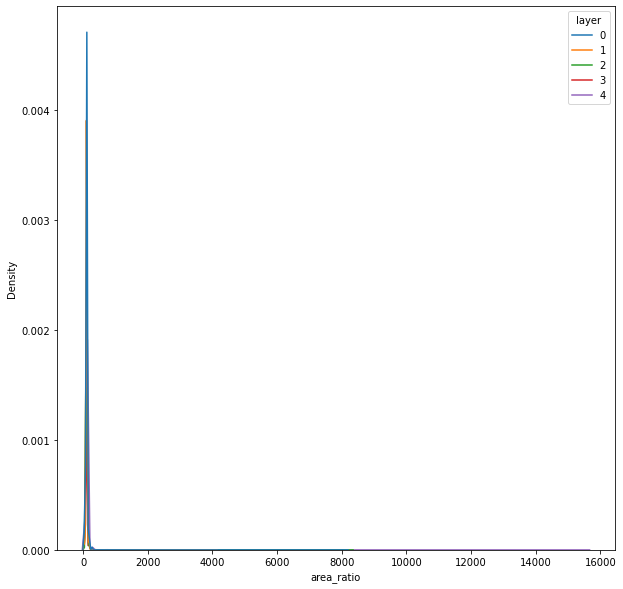

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.kdeplot(ax=ax, data=score_report, x= 'area_ratio', hue='layer', palette="tab10")

In [16]:
score_report[score_report['area_ratio']>200].groupby(by='conf_detail').groups
for key, indices in score_report[score_report['area_ratio']>200].groupby(by='layer').groups.items():
    print(f'{key}: {len(indices)}')

0: 1334
1: 987
2: 477
3: 203
4: 2660


In [17]:
print(f"number of boxes whose area is the double of the fault free model: {len(score_report[score_report['area_ratio']>200])}")
print(f"which represents the {(len(score_report[score_report['area_ratio']>200]) / len(score_report))*100}% of the total critical boxes")

number of boxes whose area is the double of the fault free model: 5661
which represents the 0.640818109988431% of the total critical boxes


In these plots we can see where are the most critical points in terms of area ratio

### Cutting off these outliers let us see the distribution

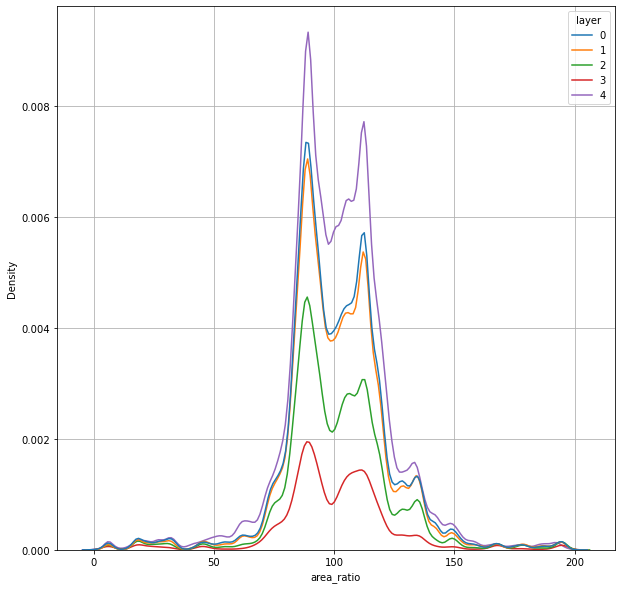

In [18]:
normal_area = score_report[score_report['area_ratio']<200]
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.kdeplot(ax=ax, data=normal_area, x= 'area_ratio', hue='layer', palette="tab10")
ax.grid()
# this is a probability, then it is already normalized. 

## Classification task evaluation

In [24]:
general_report['confidence_ratio'] = general_report['f_candidate_conf'] / general_report['G_score']
score_report = general_report.query("F_lab!=G_lab and confidence_covered==1.0")

## Confidence analysis

In [14]:
general_report['confidence_ratio'] = general_report['f_candidate_conf'] / general_report['G_score']
# score_report = general_report.query("confidence_covered==0.0")
crit_perc_per_layer_per_bit = new_report.groupby(by=["bit_faulty_position", "layer"]).mean()['Crit_perc']/100
general_report['confidence_coverage'] = general_report.groupby(by=['layer', 'bit_faulty_position'])['confidence_covered'].transform(lambda x: x.sum())
general_report['confidence_coverage']

0         106028.082148
1         106028.082148
2         106028.082148
3         106028.082148
4         106028.082148
              ...      
165305              NaN
165306              NaN
165307              NaN
165308              NaN
165309              NaN
Name: confidence_coverage, Length: 165310, dtype: float64

In [42]:
crit_perc_per_layer_per_bit = new_report.groupby(by=["bit_faulty_position", "layer"]).mean()['boxes_Crit']

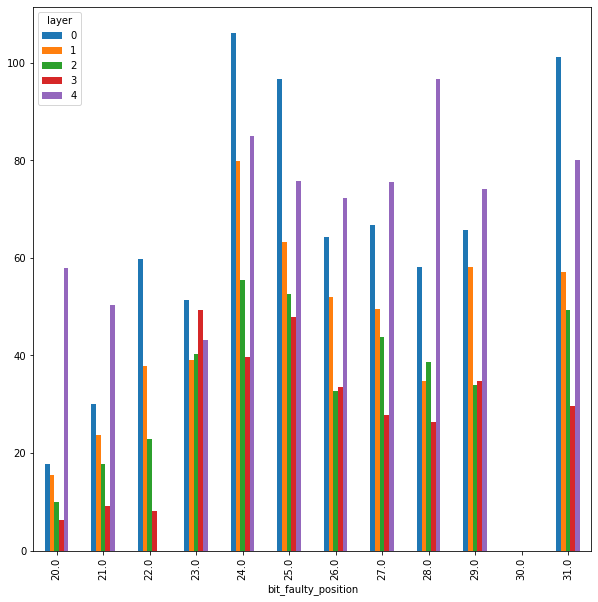

In [43]:
grouped_confidence = general_report.groupby(by=['layer', 'bit_faulty_position'])['confidence_covered'].sum()/crit_perc_per_layer_per_bit
fig, ax = plt.subplots(1,1, figsize=(10,10))
grouped_confidence.unstack().transpose().plot(kind="bar", ax = ax)
ax.grid()

Text(0.5, 1.0, 'Confidence coverage VS bit position BY configuration')

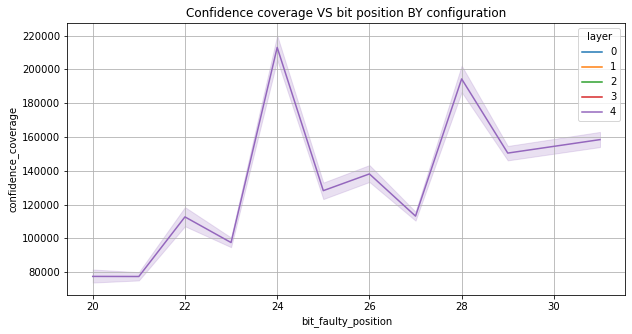

In [37]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.lineplot(ax=ax, data = general_report, x = 'bit_faulty_position', y = 'confidence_coverage', hue='layer', palette="tab10")
ax.grid()
ax.set_title("Confidence coverage VS bit position BY configuration")
